FILE PATH AND DICTIONARIES

In [1]:
DATA = './downloaded_lexica/'

AFINN = 'AFINN-111.txt'

NRC = 'NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'

BING_POS = 'bing-positive-words.txt'

BING_NEG = 'bing-negative-words.txt'


MODULES

In [2]:
# essential modules imported

import pandas as pd
import os
from collections import Counter
import numpy as np 
import re
import matplotlib.pyplot as plt


GENERIC FUNCTION TO LOAD LEXICA

In [ ]:
def load_lexicon_generic(filepath, sep='\t', score_col=None, sentiment_col=None, fixed_sentiment=None, encoding='latin-1'):
    """
    Loads a lexicon file into a standardized DataFrame format.
    """
    words = []
    scores = []
    sentiments = []

    with open(filepath, 'r', encoding=encoding) as f: 
        for line in f:
            line = line.strip()
            if not line or line.startswith(';'): # Skip empty lines or comments (Bing files)
                continue
            parts = line.split(sep)

            # 1. Word (always in col 0)
            words.append(parts[0].lower())

            # 2. Numeric Score or default to 1
            if score_col is not None and len(parts) > score_col:
                try:
                    scores.append(int(parts[score_col]))
                except ValueError:
                    scores.append(0) # Manage non-integer scores gracefully
            else:
                scores.append(1)

            # 3. Sentiment/Emotion (NRC) or fixed sentiment (Bing)
            if sentiment_col is not None and len(parts) > sentiment_col:
                sentiments.append(parts[sentiment_col].lower())
            elif fixed_sentiment is not None:
                sentiments.append(fixed_sentiment)
            else:
                sentiments.append(None)

    # Dataframe creation
    df = pd.DataFrame({
        'word': words,
        'score': scores,
        'sentiment': sentiments
    })

    # Clean up for NRC: keep only rows where score == 1
    if sentiment_col is not None:
        df = df[df['score'] == 1].copy()

    return df 

In [4]:
# 1. Load AFINN (scoring in col 1)
afinn_df = load_lexicon_generic(DATA + AFINN, score_col=1)
afinn_dict = {}

afinn_words = list(afinn_df['word'])
afinn_scores = list(afinn_df['score'])

for i in range(len(afinn_words)):
    word = afinn_words[i]
    score = afinn_scores[i]

    afinn_dict[word] = score

# 2. Load NRC (emotions in col 1, flag 0/1 in col 2)
nrc_df = load_lexicon_generic(DATA + NRC, sentiment_col=1, score_col=2)
nrc_dict = {}

nrc_words = list(nrc_df['word'])
nrc_sentiments = list(nrc_df['sentiment'])

for i in range(len(nrc_words)):
    word = nrc_words[i]
    sentiment = nrc_sentiments[i]

    if word not in nrc_dict:
        nrc_dict[word] = []
        
    nrc_dict[word].append(sentiment)

# 3. Load BING (separate files, assign fixed sentiment inside the function)
bing_pos = load_lexicon_generic(DATA + BING_POS, fixed_sentiment='positive')
bing_neg = load_lexicon_generic(DATA + BING_NEG, fixed_sentiment='negative')
bing_df = pd.concat([bing_pos, bing_neg], ignore_index=True)

bing_dict = {}

bing_words = list(bing_df['word'])
bing_sentiments = list(bing_df['sentiment'])

for i in range(len(bing_words)):
    word = bing_words[i]
    sentiment = bing_sentiments[i]

    bing_dict[word] = sentiment

print("All lexica loaded successfully.")

All lexica loaded successfully.


Sentiment Analysis

In [5]:
def analyse_generic(phrase, lexicon_type, lexicon_df):
    words = phrase.lower().split()
    
    if lexicon_type.lower() == 'afinn':
        score = 0
        matched_words = []
        word_scores = []

        for w in words:
            val = lexicon_df.get(w, 0)
            if val != 0:
                score += val
                matched_words.append(w)
                word_scores.append((w, val))

        num_words = len(words)

        if num_words > 0:
            average_score = score / num_words
        else:
            average_score = 0

        return {
            'total_score': score,
            'average_score': average_score,
            'matched_words': matched_words,
            'word_scores': word_scores
        }
    
    elif lexicon_type.lower() == 'bing':
        pos_count = 0
        neg_count = 0
        pos_words = []
        neg_words = []

        for w in words:
            sentiment = lexicon_df.get(w, None)

            if sentiment == 'positive':
                pos_count += 1
                pos_words.append(w)
            elif sentiment == 'negative':
                neg_count += 1
                neg_words.append(w)

        return {
            'positive_count': pos_count,
            'negative_count': neg_count,
            'net_sentiment': pos_count - neg_count,
            'positive_words': pos_words,
            'negative_words': neg_words
        }
    
    elif lexicon_type.lower() == 'nrc':
        # Initialize counters
        emotion_counts = Counter()

        nrc_pos_words = []
        nrc_neg_words = []
        matched_words = {}

        for w in words:
            # Look for all emotions associated with the word
            emotions = lexicon_df.get(w, [])

            for e in emotions:
                emotion_counts[e] += 1
                # Keep track of which words matched which emotions
                matched_words.setdefault(e, []).append(w)

                if e == 'positive':
                    nrc_pos_words.append(w)
                elif e == 'negative':
                    nrc_neg_words.append(w)

        nrc_pos_count = emotion_counts ['positive']
        nrc_neg_count = emotion_counts ['negative']
        net_score = nrc_pos_count - nrc_neg_count

        return {
            'lexicon': 'NRC',
            'total matches': sum(emotion_counts.values()),
            'emotion_counts': dict(emotion_counts),
            'matched_words': matched_words,
            'positive_count': nrc_pos_count,
            'negative_count': nrc_neg_count,
            'positive_words': nrc_pos_words,
            'negative_words': nrc_neg_words,
            'net_score': net_score
        }
    
    else:
        raise ValueError(f"Unknown lexicon type: {lexicon_type}")


In [6]:
def score_phrase(phrase, lexicon_type, lexicon_df):
    return analyse_generic(phrase, lexicon_type, lexicon_df)

EXAMPLE ANALYSIS

In [7]:
# Example phrase: afinn and bing are unable to pick up a signal
myphrase = "I love you but I hate the current political situation"

In [8]:

afinn_res = score_phrase(myphrase, 'afinn', afinn_dict)
bing_res  = score_phrase(myphrase, 'bing',  bing_dict)
nrc_res   = score_phrase(myphrase, 'nrc',   nrc_dict)

print("\nAFINN result:")
print(f"  Total Score: {afinn_res['total_score']}")
print(f"  Average Score: {afinn_res['average_score']}")
print(f"  Matched Words: {afinn_res['matched_words']}")
print(f"  Word Scores: {afinn_res['word_scores']}")

print("\nBING result:")
print(f"  Positive Count: {bing_res['positive_count']}")
print(f"  Negative Count: {bing_res['negative_count']}")
print(f"  Net Sentiment: {bing_res['net_sentiment']}")
print(f"  Positive Words: {bing_res['positive_words']}")
print(f"  Negative Words: {bing_res['negative_words']}")

print("\nNRC result:")
print(f"  Total Matches: {nrc_res['total matches']}")
print(f"  Net Score: {nrc_res['net_score']}")
print(f"  Positive Words: {nrc_res['positive_words']}")
print(f"  Negative Words: {nrc_res['negative_words']}")

for emotion, words in nrc_res['matched_words'].items():
    print(f"    {emotion.capitalize()}: {words}")




AFINN result:
  Total Score: 0
  Average Score: 0.0
  Matched Words: ['love', 'hate']
  Word Scores: [('love', 3), ('hate', -3)]

BING result:
  Positive Count: 1
  Negative Count: 1
  Net Sentiment: 0
  Positive Words: ['love']
  Negative Words: ['hate']

NRC result:
  Total Matches: 7
  Net Score: 0
  Positive Words: ['love']
  Negative Words: ['hate']
    Joy: ['love']
    Positive: ['love']
    Anger: ['hate']
    Disgust: ['hate']
    Fear: ['hate']
    Negative: ['hate']
    Sadness: ['hate']


BATCH ANALYSIS

In [16]:
class SentimentAnalyzer:
    def __init__(self, afinn_dict, bing_dict, nrc_dict):

        """ 
        Initializes the SentimentAnalyzer with given lexicons.
        
        """
       
        self.afinn = afinn_dict
        self.bing = bing_dict
        self.nrc = nrc_dict

    def analyze_file(self, file_path):

        """
        Analyzes a text file and computes sentiment scores using AFINN, BING, and NRC lexicons.
        
        """
        try:
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                content = f.read()
            
            words = re.findall(r'\w+', content.lower())
            
            total_words = len(words)
            if total_words == 0: return None

        # 1. AFINN Score

            afinn_score = 0

            bing_pos = 0
            bing_neg = 0

            nrc_pos = 0
            nrc_neg = 0

            for w in words:

                afinn_score += self.afinn.get(w, 0)
        
        # 2. BING Score

                bing_sentiment = self.bing.get(w, None)
                if bing_sentiment == 'positive':
                    bing_pos += 1
                elif bing_sentiment == 'negative':
                    bing_neg += 1
        
        # 3. NRC Score

                nrc_emotions = self.nrc.get(w, [])
                if 'positive' in nrc_emotions:
                    nrc_pos += 1
                if 'negative' in nrc_emotions:
                    nrc_neg += 1
        

        # Final normalized scores

            return {

                'Word_Count': total_words,
                'AFINN_Avg': afinn_score / total_words if total_words > 0 else 0,
                'BING_Net_Norm': (bing_pos - bing_neg) / total_words,
                'NRC_Net_Norm': (nrc_pos - nrc_neg) / total_words
            }
        
        except Exception as e:
            print(f"Technical error in file {file_path}: {e}")
            return None

    def run_batch(self, base_path):
        results = []
        # Lookup for folders ending with txts
        folders = [f for f in os.listdir(base_path) if f.endswith("txts")]
        
        if not folders:
            print(f"Error: no folders ending with 'txts' found in {os.path.abspath(base_path)}")
            return pd.DataFrame()

        for folder in folders:
            president = folder.replace("txts", "")
            path = os.path.join(base_path, folder)
            print(f"Processing data for: {president}...")
            
            for file in os.listdir(path):
                if file.endswith(".txt"):
                    try:
                        # extract date from filename
                        clean_name = file.replace(".txt", "")
                        parts = clean_name.split('_')
                        
                        if len(parts) >= 4:
                            # Clean up the sentence day from possible typos
                            day = re.sub(r'[^0-9]', '', parts[3])
                            date_str = f"{parts[1]} {parts[2]} {day}"
                            file_date = pd.to_datetime(date_str)
                            
                            res = self.analyze_file(os.path.join(path, file))
                            if res:
                                res.update({'Date': file_date, 'President': president})
                                results.append(res)
                    except Exception as e:
                        continue
        
        if not results:
            return pd.DataFrame()
            
        return pd.DataFrame(results).sort_values(by='Date')

# --- EXECUTION ---

analyzer = SentimentAnalyzer(afinn_dict, bing_dict, nrc_dict)

current_folder = os.getcwd()
path_to_texts = os.path.join(current_folder, 'Data', 'Presidents_texts')

df_results = analyzer.run_batch(path_to_texts)

if not df_results.empty:
    print("\nSUCCESS: Data collected successfully!")
    print(df_results)
else:
    print("\nATTENTION: The table is still empty")

Processing data for: Bush ...
Processing data for: Ford ...
Processing data for: Obama ...
Processing data for: Truman ...

SUCCESS: Data collected successfully!
    Word_Count  AFINN_Avg  BING_Net_Norm  NRC_Net_Norm       Date President
13         351   0.011396      -0.008547      0.014245 1945-05-22   Truman 
14         632   0.068038       0.042722      0.050633 1946-02-20   Truman 
15         277   0.083032       0.046931      0.104693 1950-12-05   Truman 
16         215   0.111628       0.055814      0.116279 1952-04-15   Truman 
17        1051   0.007612      -0.002854      0.036156 1953-01-17   Truman 
6          233   0.085837       0.012876      0.042918 1974-09-17     Ford 
7          709   0.043724       0.032440      0.090268 1975-05-30     Ford 
8         5673   0.045479       0.024326      0.054292 1976-10-28     Ford 
1         2341   0.101239       0.051687      0.053823 1989-01-20     Bush 
0          319   0.047022       0.021944      0.037618 1989-02-27     Bush 
2 

In [10]:
# Extraction of Gallup data from HTML files
files = {
    'Truman': 'Truman.html',
    'Ford': 'Ford.html',
    'Bush': 'Bush.html',
    'Obama': 'Obama.html'
}

all_gallup_data = []

current_folder = os.getcwd()
path_to_html = os.path.join(current_folder, 'Data', 'Approval')

print("Starting definitive extraction (position-based)...")

for president_name, filename in files.items():

    full_path = os.path.join(path_to_html, filename)
    if os.path.exists(full_path):
        try:
            # 1. Read all tables
            tables = pd.read_html(full_path)
            
            # 2. Find the right table by its shape (Gallup tables are long and have ~6-7 columns)
            target_df = None
            for t in tables:
                # The survey table usually has more than 20 rows and 5+ columns
                if len(t) > 20 and t.shape[1] >= 5:
                    # Check if 'Approving' or 'Disapproving' exists in the text
                    if t.to_string().find('Approving') != -1:
                        target_df = t
                        break
            
            if target_df is not None:
                # 3. Create a clean dataframe by selecting columns by POSITION
                # Based on the file Ford.html:
                # Column 1: Start Date
                # Column 4: Approval %
                # Column 5: Disapproval %
                
                temp_df = pd.DataFrame()
                
                # Use .iloc to avoid looking for column names
                temp_df['Date'] = pd.to_datetime(target_df.iloc[:, 1], format='%m/%d/%Y', errors='coerce')
                temp_df['Approval'] = pd.to_numeric(target_df.iloc[:, 4], errors='coerce')
                temp_df['Disapproval'] = pd.to_numeric(target_df.iloc[:, 5], errors='coerce')
                temp_df['President'] = president_name
                
                # Remove rows that are not data (like headers or empty rows)
                clean_df = temp_df.dropna(subset=['Date', 'Approval']).copy()
                
                if not clean_df.empty:
                    all_gallup_data.append(clean_df)
                    print(f"✅ {president_name}: Successfully loaded {len(clean_df)} rows.")
            else:
                print(f"❌ {president_name}: Survey table not detected.")
                
        except Exception as e:
            print(f"❌ {president_name}: Error -> {e}")

# 4. Final Merge
if all_gallup_data:
    df_gallup_final = pd.concat(all_gallup_data).sort_values('Date')
    print("\n--- EXTRACTION SUCCESSFUL ---")
    display(df_gallup_final)
else:
    print("\n[CRITICAL ERROR] No tables found. Ensure the file names match exactly.")

Starting definitive extraction (position-based)...
✅ Truman: Successfully loaded 65 rows.
✅ Ford: Successfully loaded 36 rows.
✅ Bush: Successfully loaded 158 rows.
✅ Obama: Successfully loaded 2787 rows.

--- EXTRACTION SUCCESSFUL ---


,Date,Approval,Disapproval,President
68,1945-05-29,86.0,2.0,Truman
67,1945-08-22,91.0,2.0,Truman
66,1945-10-03,80.0,8.0,Truman
65,1945-10-31,75.0,13.0,Truman
64,1946-01-03,63.0,22.0,Truman
...,...,...,...,...
8,2017-01-12,57.0,39.0,Obama
7,2017-01-13,57.0,38.0,Obama
6,2017-01-14,57.0,39.0,Obama
5,2017-01-15,58.0,38.0,Obama


DATA MERGING

In [11]:
# --- MERGING SPEECH DATA WITH GALLUP POLLS ---
# 1. CLEANING NAMES: Strip any invisible spaces and make them identical

df_results['President'] = df_results['President'].astype(str).str.strip()
df_gallup_final['President'] = df_gallup_final['President'].astype(str).str.strip()

# 2. ENSURING DATETIME: Force both date columns to be real timestamps
df_results['Date'] = pd.to_datetime(df_results['Date'], errors='coerce')
df_gallup_final['Date'] = pd.to_datetime(df_gallup_final['Date'], errors='coerce')

# 3. SORTING: merge_asof REQUIRES both tables to be sorted by date
df_results = df_results.sort_values('Date').dropna(subset=['Date'])
df_gallup_final = df_gallup_final.sort_values('Date').dropna(subset=['Date'])

# 4. THE X-MERGE (Nearest poll to each speech)
df_merged = pd.merge_asof(
    df_results, 
    df_gallup_final, 
    on='Date', 
    by='President', 
    direction='nearest'
)

# 5. DIAGNOSTIC PRINT
nan_count = df_merged['Approval'].isna().sum()
print(f"--- Merge Diagnostic ---")
print(f"Total speeches: {len(df_merged)}")
print(f"Speeches matched with a poll: {len(df_merged) - nan_count}")
print(f"Speeches failed (NaN): {nan_count}")

if nan_count > 0:
    print("\nUnique names in Speeches:", df_results['President'].unique())
    print("Unique names in Gallup:", df_gallup_final['President'].unique())

display(df_merged)

--- Merge Diagnostic ---
Total speeches: 18
Speeches matched with a poll: 18
Speeches failed (NaN): 0


,Word_Count,AFINN_Avg,BING_Net_Norm,NRC_Net_Norm,Date,President,Approval,Disapproval
0,351,0.011396,-0.008547,0.014245,1945-05-22,Truman,86.0,2.0
1,632,0.068038,0.042722,0.050633,1946-02-20,Truman,48.0,38.0
2,277,0.083032,0.046931,0.104693,1950-12-05,Truman,33.0,52.0
3,215,0.111628,0.055814,0.116279,1952-04-15,Truman,28.0,60.0
4,1051,0.007612,-0.002854,0.036156,1953-01-17,Truman,32.0,56.0
5,233,0.085837,0.012876,0.042918,1974-09-17,Ford,49.0,28.0
6,709,0.043724,0.032440,0.090268,1975-05-30,Ford,50.0,32.0
7,5673,0.045479,0.024326,0.054292,1976-10-28,Ford,53.0,32.0
8,2341,0.101239,0.051687,0.053823,1989-01-20,Bush,51.0,6.0
9,319,0.047022,0.021944,0.037618,1989-02-27,Bush,62.0,13.0


SCATTER PLOT

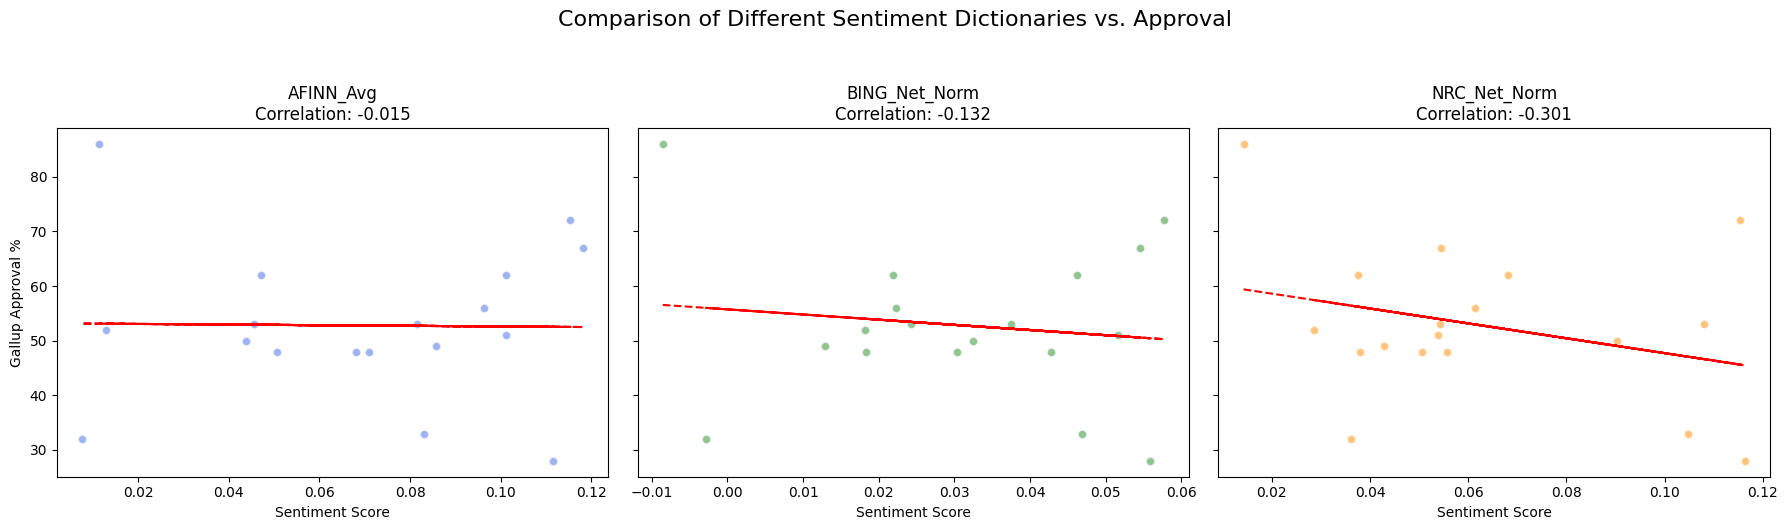

In [12]:

# 1. Define the dictionaries we want to compare
dictionaries = ['AFINN_Avg', 'BING_Net_Norm', 'NRC_Net_Norm']
colors_dict = ['royalblue', 'forestgreen', 'darkorange']

# 2. Create a figure with 3 subplots (one for each dictionary)
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, dict_name in enumerate(dictionaries):
    x = df_merged[dict_name].values
    y = df_merged['Approval'].values
    
    # Remove NaN for regression
    idx = np.isfinite(x) & np.isfinite(y)
    
    # Scatter plot on the specific subplot
    axes[i].scatter(x, y, alpha=0.5, c=colors_dict[i], edgecolors='white')
    
    # Add Trendline
    slope, intercept = np.polyfit(x[idx], y[idx], 1)
    axes[i].plot(x, slope*x + intercept, color='red', linestyle='--')
    
    # Calculate correlation for the title
    corr = df_merged[dict_name].corr(df_merged['Approval'])
    
    axes[i].set_title(f'{dict_name}\nCorrelation: {corr:.3f}')
    axes[i].set_xlabel('Sentiment Score')
    if i == 0:
        axes[i].set_ylabel('Gallup Approval %')

plt.suptitle('Comparison of Different Sentiment Dictionaries vs. Approval', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

CONTENT-LENGHT BIAS

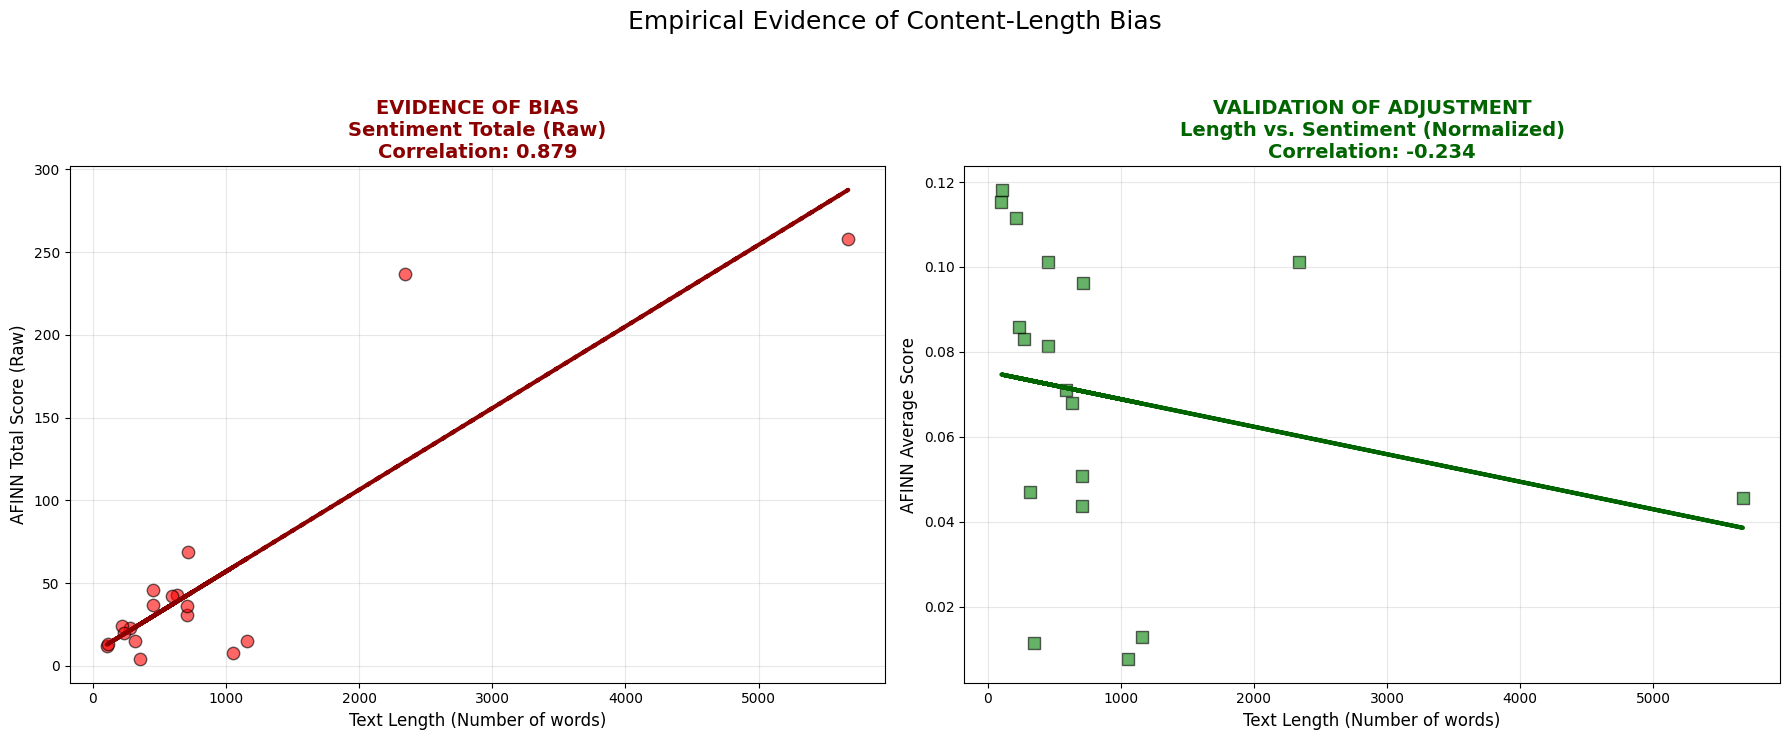

In [ ]:
# We multiply back to get the raw score to demonstrate length bias

df_merged ['AFINN_Raw'] = df_merged ['AFINN_Avg'] * df_merged['Word_Count']

# --- Length Bias Check ---

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- PLOT A: Lenght vs Raw
# Hypothesis: There is a strong correlation (ERROR)
x = df_merged ['Word_Count']
y_raw = df_merged ['AFINN_Raw']
corr_raw = x.corr(y_raw)

axes[0].scatter(x, y_raw, color='red', alpha=0.6, edgecolors='k', s=80)

# Trendline
m, q = np.polyfit(x, y_raw, 1)
axes[0].plot(x, m*x + q, color='darkred', linewidth=3, linestyle='--')

axes[0].set_title(f"EVIDENCE OF BIAS\nSentiment Totale (Raw)\nCorrelation: {corr_raw:.3f}", 
                  fontsize=14, fontweight='bold', color='darkred')
axes[0].set_xlabel("Text Length (Number of words)", fontsize=12)
axes[0].set_ylabel("AFINN Total Score (Raw)", fontsize=12)
axes[0].grid(alpha=0.3)

# --- PLOT B: THE SOLUTION (Length vs Normalized) ---
# Hypothesis: No significant correlation exists
y_norm = df_merged ['AFINN_Avg']
corr_norm = x.corr(y_norm)

axes[1].scatter(x, y_norm, color='green', marker='s', alpha=0.6, edgecolors='k', s=80)

# Trendline
m, q = np.polyfit(x, y_norm, 1)
axes[1].plot(x, m*x + q, color='darkgreen', linewidth=3, linestyle='-')

axes[1].set_title(f"VALIDATION OF ADJUSTMENT\nLength vs. Sentiment (Normalized)\nCorrelation: {corr_norm:.3f}", 
                  fontsize=14, fontweight='bold', color='darkgreen')
axes[1].set_xlabel("Text Length (Number of words)", fontsize=12)
axes[1].set_ylabel("AFINN Average Score", fontsize=12)
axes[1].grid(alpha=0.3)

plt.suptitle("Empirical Evidence of Content-Length Bias", fontsize=18, y=1.05)
plt.tight_layout()
plt.show()